In [16]:
# %load house.py
#!/usr/bin/env python3

#####################################################
#                                                   #
#    U.S. HOUSE STATISTICAL PREDICTIONS             #
#    CORY McCARTAN                                  #
#                                                   #
#####################################################


import math
import re
import pickle
import os
import argparse
import json
from datetime import date, datetime, timedelta
import time
from urllib.request import urlopen as fetch
from types import SimpleNamespace as dot
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sb


from bs4 import BeautifulSoup
import pollster
pollster = pollster.Api()

import pandas as pd
import numpy as np
from pystan import StanModel 
import us

import priors


def get_polling_data(year=2018, max_date=None):
    nov_1 = date(year, 11, 1)
    election_day = nov_1 + timedelta(days=(1 - nov_1.weekday() + 7) % 7)

    polls = pollster.questions_slug_poll_responses_clean_tsv_get(f"{str(year)[-2:]}-US-House")
    polls = polls[polls.sample_subpopulation.isin(["Likely Voters", "Registered Voters"])]
    polls.rename(columns={"observations": "n_resp"}, inplace=True)

    if max_date is not None:
        polls = polls[polls.end_date <= max_date]

    polls["n_dem"] = polls.Democrat / (polls.Democrat + polls.Republican) * polls.n_resp
    polls.dropna(subset=["n_dem"], inplace=True)
    polls.n_dem = polls.n_dem.astype("int")
    polls.n_resp = polls.n_resp.astype("int")

    polls["pollster"] = pd.factorize(polls.survey_house)[0] + 1
    weeks = (election_day - polls.start_date).apply(lambda x: int(x.days / 7))
    months = (election_day - polls.start_date).apply(lambda x: int(x.days / 30.4375))
    n_weeks = weeks.max() + 1
    n_months = months.max() + 1
    polls["week"] = n_weeks - weeks
    polls["month"] = n_months - months

    polls.drop(["Democrat", "Republican", "Other", "Undecided", "survey_house", "start_date",
                "end_date", "sample_subpopulation", "mode", "partisanship", "partisan_affiliation",
                "poll_slug", "question_text", "margin_of_error"], axis=1, inplace=True)

    return polls, n_weeks, n_months

def find_not_running(year):
    page = fetch(f"https://en.wikipedia.org/wiki/United_States_House_of_Representatives_elections,_{year}")
    soup = BeautifulSoup(page, "lxml")
    # find the section that mentions retiring incumbents
    incumbents = soup.find("span", class_="mw-headline", string=re.compile("incumbent", re.I)).parent
    not_running = []
    # there is a list for each party
    for l in incumbents.find_next_siblings("ol"):
        for item in l.find_all("li"):
            # each item is like 'Arizona 1: John Smith.' We extract the state and district # 
            state, district = item.get_text().split(":")[0].split("\xa0")
            district = 0 if district.lower() == "at-large" else int(district)
            not_running.append(f"{name_to_abbr(state)}-{district:02}")

    return not_running

def get_incumbency():
    data = []
    
    page = fetch("https://en.wikipedia.org/wiki/Current_members_of_the_United_States_House_of_Representatives")
    soup = BeautifulSoup(page, "lxml")
    
    heading = soup.find("span", id="Voting_members_by_state").parent
    table = heading.find_next_sibling("table")
   
    first = True
    for row in table.find_all("tr"):
        # skip first row (headings)
        if first:
            first = False
            continue
            
        district, _, _, party, *_ = [c.text for c in row.find_all("td")]
        state, district = re.split(' (?=at large|\d)', district.lower())
        district = 0 if district == "at large" else int(district)
        party = 1 if party == "Democratic" else -1 if party == "Republican" else 0
        
        data.append({
            "district": f"{name_to_abbr(state)}-{district:02}",
            "incumbent": party
        })
    
    return pd.DataFrame(data).sort_values("district").set_index("district", drop=False)

def name_to_abbr(name):
    return us.states.lookup(name).abbr



In [5]:
args = dot(dry=False, date=datetime.now(), race_n=20000, nat_n=3000, recompile=False,
          model_dir="models")

election_day = datetime(2018, 11, 6)
current_seats = 194

#################################
# Load prior models             #
#################################
nat_prior = priors.get_national_prior(model_dir=args.model_dir)
race_prior = priors.get_race_prior(model_dir=args.model_dir)
bias_prior = priors.get_bias_prior(recalculate=True, model_dir=args.model_dir)

In [38]:
#################################
# Organize data for prediction  #
#################################

approvals = priors.get_approvals_data()
cd_vote = priors.get_pvi_data()

polls, n_weeks, n_months = get_polling_data(max_date = args.date)

if args.date >= datetime(2018, 6, 1):
    appr_slice = approvals[(approvals.date > date(2018, 1, 1))
                            & (approvals.date < date(2018, 6, 1))]
else: # use last six months
    ago = args.date - timedelta(6 * 365/12)
    appr_slice = approvals[(approvals.date > ago) & (approvals.date < args.date)]

nat_prior_data = [{
    "APPR": appr_slice.approval.mean(),
    "INC": -1,
    "PRES": -1,
    "MID": 1,
}]
nat_prediction = nat_prior.predict(nat_prior_data)[0]

# create covariance matrix for national polling error
sigma_cov = np.full((n_months, n_months), 0.0)
np.fill_diagonal(sigma_cov, bias_prior.mse_resid / 100**2)
diag = np.arange(0, n_months - 1)
sigma_cov[diag + 1, diag] = bias_prior.step_var
sigma_cov[diag, diag+1] = bias_prior.step_var

mcmc_data = {
    "R": 435,
    "W": n_weeks,
    "M": n_months,
    "N": len(polls),
    "P": max(polls.pollster),
    "w": polls.week.values,
    "m": polls.month.values,
    "n_resp": polls.n_resp.values,
    "n_dem": polls.n_dem.values,
    "p": polls.pollster.values,
    "alpha_n_prior": bias_prior.predict({"months": range(n_months-1, -1, -1)}).values / 100,
    "sigma_n_prior": sigma_cov,
    "mu_prior": nat_prediction / 100,
    "mu_mse": math.sqrt(nat_prior.mse_resid) / 100,
}


#################################
# Compile and run STAN model    #
#################################

filename = "house_stan.pkl"
path = os.path.join(args.model_dir, filename)

if os.path.isfile(path) and not args.recompile:
    with open(path, "rb") as f:
        model = pickle.load(f)
else:
    model = StanModel(file="house.stan")
    with open(path, "wb") as f:
        pickle.dump(model, f)


fit = model.sampling(data=mcmc_data, chains=3, iter=args.nat_n, 
        warmup=args.nat_n // 3)


#################################
# Extract results               #
#################################

mu_samples = fit.extract("mu")["mu"]
y = 100 * np.mean(mu_samples, axis=0)
err_y = 100 * np.std(mu_samples, axis=0)
weeks = pd.date_range(end=election_day, periods=n_weeks, freq="W")
weeks = weeks.strftime("%Y-%m-%d")


alpha_samples = fit.extract("alpha_n")["alpha_n"]
alpha = 100 * np.mean(alpha_samples, axis=0)
err_alpha = 2 * 100 * np.std(alpha_samples, axis=0)

In [86]:
#################################
# Predict individual races      #
#################################

incumbents = get_incumbency()
not_running = find_not_running(2018)

race_prior_data = []
races = incumbents.district.unique()
incumbent_series = []
for race in races:
    incumbent_series.append(incumbents.loc[race].incumbent)
    race_prior_data.append({ 
        "NAT": y[-1],
        "INC": 0 if race in not_running else incumbents.loc[race].incumbent,
        "PVI": cd_vote.loc[race].pvi_2018,
        "ADJ": cd_vote.loc[race].pres_margin_16,
        "MID": 1,
        "PRES": -1,
    })

race_predictions = race_prior.predict(race_prior_data).values / 100

# add in variance from national model
addl_var = (err_y[-1] / 100)**2
cov_matrix = np.full((435, 435), race_prior.mse_resid/100**2)
np.fill_diagonal(cov_matrix, race_prior.dist_var/100**2)

results = np.random.multivariate_normal(race_predictions, cov_matrix, args.race_n)

expected = results.mean(axis=0)
expected_std = results.std(axis=0)
prob_district = np.mean((np.sign(results) + 1) / 2, axis=0)
seats = np.sum((np.sign(results) + 1) / 2, axis=1).astype(int)
seats_hist = np.bincount(seats, minlength=436) / len(seats)
prob = np.mean(seats >= 218)
gain = np.mean(seats) - current_seats

In [87]:
print(prob)
print(gain)

0.3789
28.0652


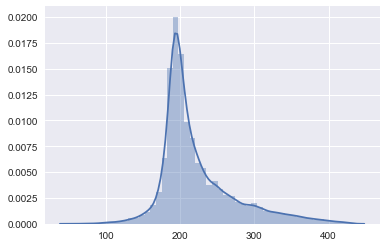

In [88]:

sb.distplot(seats)

In [71]:
prob_district[idx]

0.3332

In [46]:
distr = "CA-49"
idx = np.where(races == distr)[0][0]
d = race_prior_data[idx].copy()
print(d)
race_prior.predict([d]).values[0]

{'NAT': 5.8342912068314625, 'INC': -1, 'PVI': -1.0, 'ADJ': 8.0, 'MID': 1, 'PRES': -1}


-7.1001552632329084

In [67]:
import statsmodels.formula.api as smf

mf = smf.ols("MRG ~ INC + PVI + ADJ + NAT + PRES*MID", data=race_prior.model.data.frame).fit()
print(mf.summary())

                            OLS Regression Results                            
Dep. Variable:                    MRG   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     1984.
Date:                Mon, 17 Jul 2017   Prob (F-statistic):               0.00
Time:                        21:17:58   Log-Likelihood:                -10482.
No. Observations:                2592   AIC:                         2.098e+04
Df Residuals:                    2584   BIC:                         2.103e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3924      0.472      5.073      0.0

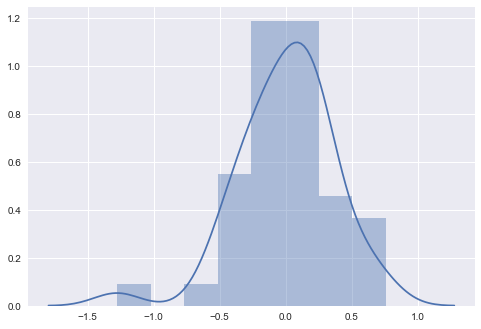

In [53]:
sb.distplot(fit.extract("u")["u"].mean(axis=0))

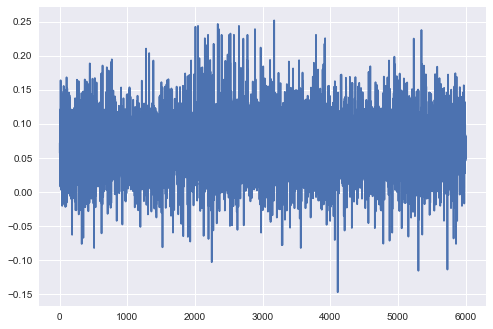

In [41]:
plt.plot(fit.extract("mu")["mu"][:,5])

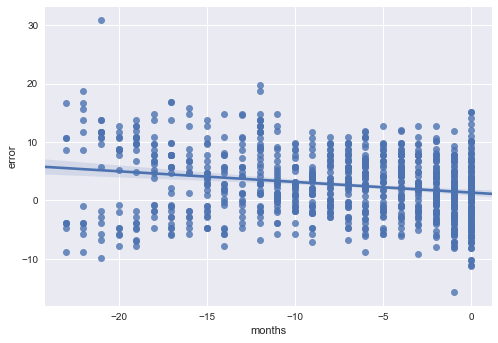

In [32]:
bd = bias_prior.model.data.frame
sb.regplot(-bd.months, bd.error)

In [26]:
math.sqrt(bias_prior.mse_resid)

5.50320854609693

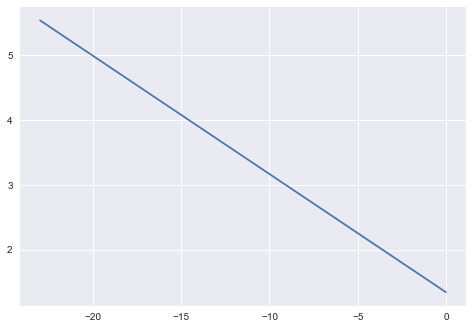

In [28]:
plt.plot(-bd.months, bias_prior.fittedvalues)

In [37]:
bias_prior.fittedvalues.iloc[0]

1.343503914690005